In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud 

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import  train_test_split
from sklearn.metrics import classification_report, accuracy_score

2024-02-16 19:14:07.877685: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 19:14:07.877806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 19:14:08.148330: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [22]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fake-news-detection/true.csv
/kaggle/input/fake-news-detection/fake.csv


In [23]:
fake = pd.read_csv('/kaggle/input/fake-news-detection/fake.csv')

In [24]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [25]:
true = pd.read_csv('/kaggle/input/fake-news-detection/true.csv')

In [26]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [27]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [28]:
fake['subject'].value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

<Axes: xlabel='subject', ylabel='count'>

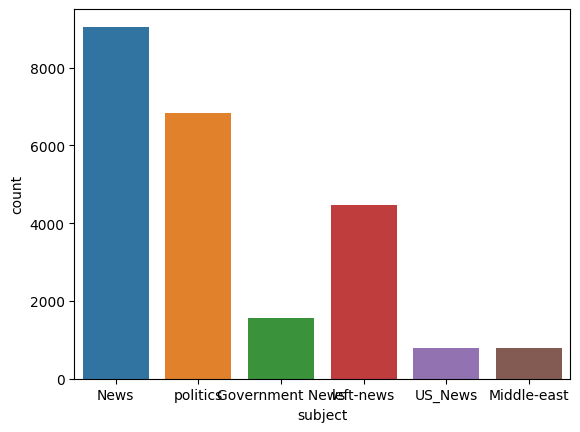

In [29]:
sns.countplot(x='subject',data=fake)

In [30]:
text = ' '.join(fake['text'].tolist())

# Visualizations

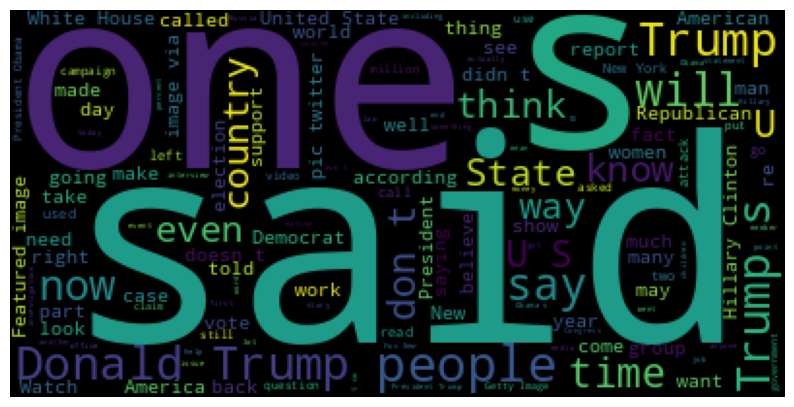

In [31]:
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(10,20))
# Display the generated image:
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [32]:
true.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [33]:
true['subject'].value_counts()

subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64

In [34]:
text = ' '.join(true['text'].tolist())

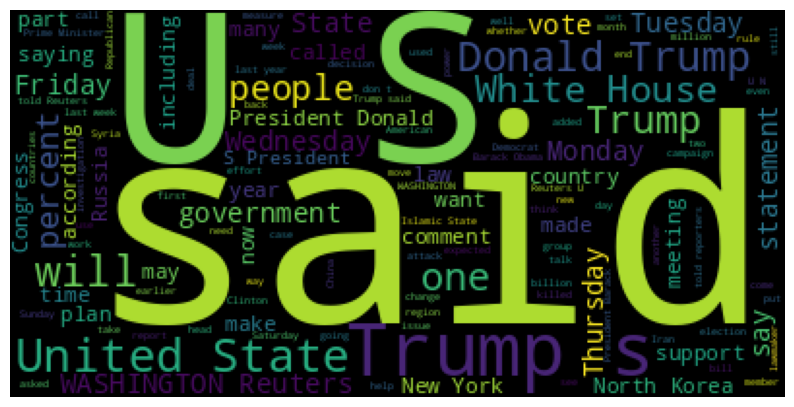

In [35]:
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(10,20))
# Display the generated image:
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [36]:
true.sample(5)

,title,text,subject,date
5847,Travel ban protest delays Senate panel vote on...,WASHINGTON (Reuters) - U.S. Senate Democrats d...,politicsNews,"January 30, 2017"
2742,Canada's Trudeau warns against 'tempting short...,"PROVIDENCE, R.I. (Reuters) - Canadian Prime Mi...",politicsNews,"July 14, 2017"
17594,South African Supreme Court upholds reinstatin...,"BLOEMFONTEIN, South Africa (Reuters) - South A...",worldnews,"October 13, 2017"
2786,Kid Rock hints online he will run for U.S. Senate,"DETROIT (Reuters) - Recording star Kid Rock, a...",politicsNews,"July 12, 2017"
19759,People smugglers test new migrant sea route th...,BUCHAREST (Reuters) - About 500 migrants from ...,worldnews,"September 18, 2017"


In [37]:
fake.sample(5)

,title,text,subject,date
8866,Cruz Dedicates Empty Seat At State Of The Uni...,"Yesterday, President Barack Obama made a touch...",News,"January 9, 2016"
19494,$3.5 MILLION DOWN THE DRAIN….Day 5 WI Recount:...,Just think how many youth centers could have b...,left-news,"Dec 6, 2016"
13338,CNN IS EVIL: Carol Costello FAILS When Benghaz...,"Charles Woods, father of U.S. Navy SEAL Tyrone...",politics,"Aug 5, 2016"
15500,OBAMA COZIES UP TO ANOTHER COMMUNIST LEADER TO...,So much for the US refusing to work with count...,politics,"Jul 7, 2015"
16717,WATCH: HILLARY CALLS PARENT Of Benghazi Victim...,Apparently being the wife of a former Democrat...,Government News,"Mar 11, 2016"


# Data Cleaning

In [38]:
unkown_pub = []
for index, row in enumerate(true.text.values):
    try:
        record = row.split(' - ',maxsplit=1)
        record[1]
        
        assert(len(record[0])<260)
        
        
    except:
        unkown_pub.append(index)



In [39]:
len(unkown_pub)

35

In [40]:
true.iloc[unkown_pub].text

2922     The following statements were posted to the ve...
3488     The White House on Wednesday disclosed a group...
3782     The following statements were posted to the ve...
4358     Neil Gorsuch, President Donald Trump’s appoint...
4465     WASHINGTON The clock began running out this we...
5290     The following statements were posted to the ve...
5379     The following statements were posted to the ve...
5412     The following statements were posted to the ve...
5504     The following statements were posted to the ve...
5538     The following statements were posted to the ve...
5588     The following statements were posted to the ve...
5593     The following statements were posted to the ve...
5761     The following bullet points are from the U.S. ...
5784     Federal appeals court judge Neil Gorsuch, the ...
6026     The following bullet points are from the U.S. ...
6184     The following bullet points are from the U.S. ...
6660     Republican members of Congress are complaining.

In [41]:
true = true.drop(8970,axis=0)

In [42]:
publisher = []
tmp_text = []
for index, row in enumerate(true.text.values):
    if index in unkown_pub:
        tmp_text.append(row)
        publisher.append('Unknown')
    else:
        record = row.split('-',maxsplit=1)
        publisher.append(record[0].split())
        tmp_text.append(record[1].split())

In [43]:
true['publisher'] = publisher
true['text'] = tmp_text

In [44]:
true.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...","[The, head, of, a, conservative, Republican, f...",politicsNews,"December 31, 2017","[WASHINGTON, (Reuters)]"
1,U.S. military to accept transgender recruits o...,"[Transgender, people, will, be, allowed, for, ...",politicsNews,"December 29, 2017","[WASHINGTON, (Reuters)]"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,"[The, special, counsel, investigation, of, lin...",politicsNews,"December 31, 2017","[WASHINGTON, (Reuters)]"
3,FBI Russia probe helped by Australian diplomat...,"[Trump, campaign, adviser, George, Papadopoulo...",politicsNews,"December 30, 2017","[WASHINGTON, (Reuters)]"
4,Trump wants Postal Service to charge 'much mor...,"[President, Donald, Trump, called, on, the, U....",politicsNews,"December 29, 2017","[SEATTLE/WASHINGTON, (Reuters)]"


In [45]:
true.shape

(21416, 5)

In [46]:
empty_fake = [index for index,text in enumerate(fake.text.tolist()) if str(text).strip()=='']

In [47]:
fake.iloc[empty_fake]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [48]:
true['text'] = true['title'] + " " + true['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
fake['text'] = fake['title'] + " " + fake['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)


In [49]:
true.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...","As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017","[WASHINGTON, (Reuters)]"
1,U.S. military to accept transgender recruits o...,U.S. military to accept transgender recruits o...,politicsNews,"December 29, 2017","[WASHINGTON, (Reuters)]"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,Senior U.S. Republican senator: 'Let Mr. Muell...,politicsNews,"December 31, 2017","[WASHINGTON, (Reuters)]"
3,FBI Russia probe helped by Australian diplomat...,FBI Russia probe helped by Australian diplomat...,politicsNews,"December 30, 2017","[WASHINGTON, (Reuters)]"
4,Trump wants Postal Service to charge 'much mor...,Trump wants Postal Service to charge 'much mor...,politicsNews,"December 29, 2017","[SEATTLE/WASHINGTON, (Reuters)]"


In [50]:
true['text'] = true['text'].apply(lambda x: str(x).lower())
fake['text'] = fake['text'].apply(lambda x: str(x).lower())

# Preprocessing

In [51]:
true['class']=1
fake['class']=0

In [52]:
true

,title,text,subject,date,publisher,class
0,"As U.S. budget fight looms, Republicans flip t...","as u.s. budget fight looms, republicans flip t...",politicsNews,"December 31, 2017","[WASHINGTON, (Reuters)]",1
1,U.S. military to accept transgender recruits o...,u.s. military to accept transgender recruits o...,politicsNews,"December 29, 2017","[WASHINGTON, (Reuters)]",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,senior u.s. republican senator: 'let mr. muell...,politicsNews,"December 31, 2017","[WASHINGTON, (Reuters)]",1
3,FBI Russia probe helped by Australian diplomat...,fbi russia probe helped by australian diplomat...,politicsNews,"December 30, 2017","[WASHINGTON, (Reuters)]",1
4,Trump wants Postal Service to charge 'much mor...,trump wants postal service to charge 'much mor...,politicsNews,"December 29, 2017","[SEATTLE/WASHINGTON, (Reuters)]",1
...,...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,'fully committed' nato backs new u.s. approach...,worldnews,"August 22, 2017","[BRUSSELS, (Reuters)]",1
21413,LexisNexis withdrew two products from Chinese ...,lexisnexis withdrew two products from chinese ...,worldnews,"August 22, 2017","[LONDON, (Reuters)]",1
21414,Minsk cultural hub becomes haven from authorities,minsk cultural hub becomes haven from authorit...,worldnews,"August 22, 2017","[MINSK, (Reuters)]",1
21415,Vatican upbeat on possibility of Pope Francis ...,vatican upbeat on possibility of pope francis ...,worldnews,"August 22, 2017","[MOSCOW, (Reuters)]",1


In [53]:
true = true[['text','class']]
fake = fake[['text','class']]

In [54]:
fake

,text,class
0,donald trump sends out embarrassing new year’...,0
1,drunk bragging trump staffer started russian ...,0
2,sheriff david clarke becomes an internet joke...,0
3,trump is so obsessed he even has obama’s name...,0
4,pope francis just called out donald trump dur...,0
...,...,...
23476,mcpain: john mccain furious that iran treated ...,0
23477,justice? yahoo settles e-mail privacy class-ac...,0
23478,sunnistan: us and allied ‘safe zone’ plan to t...,0
23479,how to blow $700 million: al jazeera america f...,0


In [55]:
true.head()

,text,class
0,"as u.s. budget fight looms, republicans flip t...",1
1,u.s. military to accept transgender recruits o...,1
2,senior u.s. republican senator: 'let mr. muell...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge 'much mor...,1


In [56]:
data = pd.concat([true, fake], ignore_index=True)


In [57]:
data

,text,class
0,"as u.s. budget fight looms, republicans flip t...",1
1,u.s. military to accept transgender recruits o...,1
2,senior u.s. republican senator: 'let mr. muell...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge 'much mor...,1
...,...,...
44892,mcpain: john mccain furious that iran treated ...,0
44893,justice? yahoo settles e-mail privacy class-ac...,0
44894,sunnistan: us and allied ‘safe zone’ plan to t...,0
44895,how to blow $700 million: al jazeera america f...,0


In [58]:
def replace_symbol(text):
    for symbol in ['*', '?', '%', '&', '$', '(', ')', '#', '^', '@', '!', '~', '-', '+', '=', " ", ",", "'", '"',"/", "."]:
        if symbol in text:
            text = text.replace(symbol, ' ')
    return text

In [59]:
data['text'] = data['text'].apply(replace_symbol)

In [60]:
data.head()

,text,class
0,as u s budget fight looms republicans flip t...,1
1,u s military to accept transgender recruits o...,1
2,senior u s republican senator: let mr muell...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge much mor...,1


In [61]:
data

,text,class
0,as u s budget fight looms republicans flip t...,1
1,u s military to accept transgender recruits o...,1
2,senior u s republican senator: let mr muell...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge much mor...,1
...,...,...
44892,mcpain: john mccain furious that iran treated ...,0
44893,justice yahoo settles e mail privacy class ac...,0
44894,sunnistan: us and allied ‘safe zone’ plan to t...,0
44895,how to blow 700 million: al jazeera america f...,0


# Vectorization

In [62]:
import gensim

In [63]:
y = data['class'].values

In [64]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [65]:
X = [i.split() for i in data['text'].tolist()]

In [66]:
len(X)

44897

In [67]:
X[1]

['u',
 's',
 'military',
 'to',
 'accept',
 'transgender',
 'recruits',
 'on',
 'monday:',
 'pentagon',
 'transgender',
 'people',
 'will',
 'be',
 'allowed',
 'for',
 'the',
 'first',
 'time',
 'to',
 'enlist',
 'in',
 'the',
 'u',
 's',
 'military',
 'starting',
 'on',
 'monday',
 'as',
 'ordered',
 'by',
 'federal',
 'courts',
 'the',
 'pentagon',
 'said',
 'on',
 'friday',
 'after',
 'president',
 'donald',
 'trump’s',
 'administration',
 'decided',
 'not',
 'to',
 'appeal',
 'rulings',
 'that',
 'blocked',
 'his',
 'transgender',
 'ban',
 'two',
 'federal',
 'appeals',
 'courts',
 'one',
 'in',
 'washington',
 'and',
 'one',
 'in',
 'virginia',
 'last',
 'week',
 'rejected',
 'the',
 'administration’s',
 'request',
 'to',
 'put',
 'on',
 'hold',
 'orders',
 'by',
 'lower',
 'court',
 'judges',
 'requiring',
 'the',
 'military',
 'to',
 'begin',
 'accepting',
 'transgender',
 'recruits',
 'on',
 'jan',
 '1',
 'a',
 'justice',
 'department',
 'official',
 'said',
 'the',
 'administr

In [68]:

DIM = 100
# Set min_count to 1 to include all words
w2vec = gensim.models.Word2Vec(sentences=X, vector_size=DIM, window=10, min_count=1)

In [69]:
w2vec.wv

In [70]:
w2vec.wv.most_similar('trump')

[('trump’s', 0.719541072845459),
 ('he', 0.5571455955505371),
 ('trump:', 0.547950267791748),
 ('cruz', 0.5356379151344299),
 ('him', 0.5331484079360962),
 ('trump”', 0.5194746255874634),
 ('gravelly', 0.5143678188323975),
 ('rumseld', 0.5094978213310242),
 ('his', 0.5022361874580383),
 ('“he', 0.4978872835636139)]

In [71]:
w2vec.wv.most_similar('pakistan')

[('islamabad', 0.7755093574523926),
 ('india', 0.7379491329193115),
 ('afghanistan', 0.7025288343429565),
 ('taliban', 0.6789132952690125),
 ('pakistan’s', 0.6410597562789917),
 ('pakistani', 0.6311047077178955),
 ('kashmir', 0.5670267939567566),
 ('afghan', 0.5649567246437073),
 ('egypt', 0.5628143548965454),
 ('militants', 0.5598873496055603)]

In [72]:
# Assuming w2vec is your Word2Vec model
# len(w2vec.wv.vocab) is replaced by the following:
vocab_size = len(w2vec.wv.key_to_index)
vocab_size

164374

In [73]:
w2vec.wv.most_similar('pakistan')

[('islamabad', 0.7755093574523926),
 ('india', 0.7379491329193115),
 ('afghanistan', 0.7025288343429565),
 ('taliban', 0.6789132952690125),
 ('pakistan’s', 0.6410597562789917),
 ('pakistani', 0.6311047077178955),
 ('kashmir', 0.5670267939567566),
 ('afghan', 0.5649567246437073),
 ('egypt', 0.5628143548965454),
 ('militants', 0.5598873496055603)]

In [74]:
tok = Tokenizer()

In [75]:
tok.fit_on_texts(X)

In [76]:
X = tok.texts_to_sequences(X)

In [77]:
len(X[1])

643

In [78]:
a = np.array([len(x) for x in X])
a.mean()

426.88538209679933

In [79]:
maxlen = 1000
X = pad_sequences(X, maxlen=maxlen)

In [80]:
vocab_size = len(tok.word_index)+1
vocab = tok.word_index

In [81]:
def get_weight(model):
    weight_matrix = np.zeros((vocab_size,DIM))
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [82]:
embedding_vectors = get_weight(w2vec)

In [83]:
embedding_vectors.shape

(164375, 100)

# Model Creation

In [84]:
model1 = Sequential()
model1.add(Embedding(vocab_size, output_dim=DIM, weights=[embedding_vectors],input_length=maxlen, trainable=False))
model1.add(LSTM(units=128))
model1.add(Dense(1,activation='sigmoid'))

In [85]:
model1.compile(optimizer ='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [86]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         16437500  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 16554877 (63.15 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 16437500 (62.70 MB)
_________________________________________________________________


In [87]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [89]:
model1.fit(X_train,y_train,validation_split=0.2,epochs=4)

Epoch 1/4
842/842 [==============================] - 27s 32ms/step - loss: 0.0643 - accuracy: 0.9793 - val_loss: 0.0381 - val_accuracy: 0.9875
Epoch 2/4
842/842 [==============================] - 27s 32ms/step - loss: 0.0475 - accuracy: 0.9832 - val_loss: 0.0470 - val_accuracy: 0.9847
Epoch 3/4
842/842 [==============================] - 27s 32ms/step - loss: 0.0222 - accuracy: 0.9928 - val_loss: 0.0355 - val_accuracy: 0.9862
Epoch 4/4
842/842 [==============================] - 27s 32ms/step - loss: 0.0084 - accuracy: 0.9977 - val_loss: 0.0177 - val_accuracy: 0.9938


# Prediction

In [91]:
y_pred = (model1.predict(X_test)>=0.5).astype(int)

351/351 [==============================] - 5s 12ms/step


In [92]:
accuracy_score(y_test,y_pred)

0.9946547884187082

In [156]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5849
           1       0.99      1.00      0.99      5376

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



# Predicting on random news

In [143]:
news = "Across the country, Democrats are winning special elections and overperforming in elections they have predictably lost. And it's fueling optimism among Democrats looking at a challenging election year for both the White House and Congress. Polls don't vote. People vote. And that's what's been happening, says Democratic Rep. Jim McGovern, a veteran lawmaker from Massachusetts who has served in both the minority and the majority. Despite what the polls say, people have been voting, and they've been voting Democratic. I feel really good about November – and not just about the president. I feel really good about us taking back the House.".lower()

In [144]:
news = replace_symbol(news)

In [145]:
news = [news]

In [146]:
x = tok.texts_to_sequences(news)

In [147]:
x = pad_sequences(x, maxlen=maxlen)

In [148]:
x

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [149]:
X_train

array([[    0,     0,     0, ...,   216,  1309,  1427],
       [    0,     0,     0, ...,     3,   134, 13595],
       [    0,     0,     0, ...,  5666,   573,   492],
       ...,
       [    0,     0,     0, ...,  4126,   640,  3120],
       [  345, 17804,  1079, ...,   120,   128,   489],
       [    0,     0,     0, ...,   588, 89472,  6650]], dtype=int32)

In [151]:
(model1.predict(x)>=0.5).astype(int)

1/1 [==============================] - 0s 28ms/step


array([[0]])

In [152]:
news1 = 'CNN reported earlier this week that US officials have been direct in their talks with Israeli counterparts that the estimated 1.3 million people currently in the southernmost city of Rafah simply “have nowhere to go” ahead of an expected ground offensive, according to a senior administration official.'.lower()

In [153]:
news1

'cnn reported earlier this week that us officials have been direct in their talks with israeli counterparts that the estimated 1.3 million people currently in the southernmost city of rafah simply “have nowhere to go” ahead of an expected ground offensive, according to a senior administration official.'

In [154]:
news1 = [news1]
x = tok.texts_to_sequences(news1)
x = pad_sequences(x, maxlen=maxlen)
(model1.predict(x)>=0.5).astype(int)

1/1 [==============================] - 0s 29ms/step


array([[1]])